In [1]:
# Import Pandas for data structure manipulations.
import pandas as pd

# Import NumPy for numerical analysis.
import numpy as np

# Import a timer.
import time

from category_encoders import TargetEncoder

# Import the train_test_split, cross-validation, and grid search modules from Scikit-Learn.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Import the One-Hot Encoder, Target Encoder, StandardScaler for later categorical to numeric encoding.
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Import the column transformer that can be used for scaling purposes in later steps.
from sklearn.compose import make_column_transformer

# Import the pipeline module for step-wise transformations in later steps.
from sklearn.pipeline import make_pipeline

# Import the mean_squared_error module from Scikit-Learn as a quick error metric.
from sklearn.metrics import accuracy_score, make_scorer, mean_squared_error

# Import DecisionTreeClassifer and tree visualizatoin methods from Scikit-Learn.
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Use the experimental method in Scikit-Learn to enable HistGradientBoostingClassifier.
from sklearn.experimental import enable_hist_gradient_boosting

# Import the RandomForestClassifier, GradientBoostingClassifier, and HistGradientBoostingClassifier from Scikit-Learn.
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay

from sklearn.metrics import average_precision_score
# Import the XGBoost module from Scikit-Learn. Be sure to 'brew install cmake' in CLI.
# Next, 'pip install xgboost' in CLI or do a '!pip install xgboost' in iPython. This makes XGBoost accessible.
!pip install xgboost
import xgboost as xgb

# Import MatPlotLib for data exploration and visualizations.
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

# Ignore unnecessary warnings. This will clean up output appearances.
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.svm import LinearSVC, SVC

import gc

C:\Users\yh3184\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
# read training set and preprocessing 
## didn't include imputed orig_destination_distance
def train_data():
    # Specify the name of the local 'data' directory data files will be stored.
    data_folder = 'data/'

    # Specify the data file extension .csv that training and test sets will be pulled from.
    csv_extension = '.csv'
    # Grab the training data available from the data directory.
    train = pd.read_csv(data_folder + 'train' + csv_extension, parse_dates = [0,11,12])
    train = train.drop(columns=['orig_destination_distance', 'posa_continent','user_id','is_mobile'], axis = 1)
    train = train.dropna()
    
    train['srch_ci'] = pd.to_datetime(train['srch_ci'], errors='coerce')
    train['srch_co'] = pd.to_datetime(train['srch_co'], errors='coerce')
    train['srch_before_ci'] = pd.to_numeric((train['srch_ci'] - train['date_time']).dt.days, errors='coerce', downcast='integer')
    train['srch_trip_duration'] = pd.to_numeric((train['srch_co'] - train['srch_ci']).dt.days, errors='coerce', downcast='integer')
    train['day_of_year_srch'] = train['date_time'].dt.dayofyear
    train = train.dropna()
    train.reset_index(drop=True, inplace = True)
    
    train['encoded_day_of_year_srch'] = train['day_of_year_srch']
    TE_col = [
        'site_name',
        'user_location_country',
        'user_location_region',
        'user_location_city',
        'channel',
        'cnt',
        'hotel_continent',
        'hotel_country',
        'hotel_market',
        'encoded_day_of_year_srch'
    ]
    train[TE_col] = TargetEncoder(
        cols = TE_col, 
        smoothing=0
    ).fit_transform(train[TE_col].astype('category'), train['is_booking'])
    
    OHE = OneHotEncoder()
    OHE_col = [
        'srch_destination_type_id',
    ]
    train = pd.concat(
        [
            train,
            pd.DataFrame(
                OHE.fit_transform(train[OHE_col].astype('category')).toarray(), 
                columns=OHE.get_feature_names_out(OHE_col)
            )
        ],
        axis=1
    )
    train = train.drop(columns=OHE_col, axis=1)
    
    train = train.drop(columns=['srch_ci','srch_co', 'date_time', 'day_of_year_srch'], axis = 1)
    return train

In [3]:
# read destination set
def pca_dest():
    data_folder = 'data/'
    csv_extension = '.csv'
    destinations = pd.read_csv(data_folder + 'destinations' + csv_extension, index_col=0)
    pca = PCA(n_components = 0.8)
    X_pca = pca.fit_transform(destinations)
    X_pca_df = pd.DataFrame(X_pca, index=destinations.index)
    rows, cols = X_pca.shape
    return X_pca_df

In [4]:
train = train_data()

In [5]:
dest_pca = pca_dest()

In [6]:
delete_destination_id = list(set(train['srch_destination_id']) - set(dest_pca.index))

In [7]:
train.drop(train[train['srch_destination_id'].isin(delete_destination_id)].index, inplace=True)

In [8]:
train.isnull().sum()

site_name                     0
user_location_country         0
user_location_region          0
user_location_city            0
is_package                    0
channel                       0
srch_adults_cnt               0
srch_children_cnt             0
srch_rm_cnt                   0
srch_destination_id           0
is_booking                    0
cnt                           0
hotel_continent               0
hotel_country                 0
hotel_market                  0
hotel_cluster                 0
srch_before_ci                0
srch_trip_duration            0
encoded_day_of_year_srch      0
srch_destination_type_id_0    0
srch_destination_type_id_1    0
srch_destination_type_id_2    0
srch_destination_type_id_3    0
srch_destination_type_id_4    0
srch_destination_type_id_5    0
srch_destination_type_id_6    0
srch_destination_type_id_7    0
srch_destination_type_id_8    0
srch_destination_type_id_9    0
dtype: int64

In [9]:
# scaler if needed

In [10]:
#################################

In [11]:
def split_data(train, down_sample):
    # break test set, where only booking events are included
    test = train[train['is_booking'] == 1].sample(frac = 0.2, random_state=42)
    train.drop(test.index, inplace=True)
    
    # seperate target from feature 
    if down_sample == True:
        not_book = train[train['is_booking'] == 0]
        book = train[train['is_booking'] == 1]
        train = pd.concat([not_book.sample(len(book)), book])    
    print(train.shape)
    
    train_y = train['hotel_cluster'].astype('category')
    train.drop(columns=['hotel_cluster'], inplace=True)
    y_test = test['hotel_cluster'].astype('category')
    test.drop(columns=['hotel_cluster'], inplace=True)
    x_test = test
    
    # split training set to train and val
    x_train, x_val, y_train, y_val = train_test_split(train, train_y, stratify=train['is_booking'], test_size=0.2, random_state=42)
    
    return x_train, x_val, x_test, y_train, y_val, y_test

In [12]:
x_train, x_val, x_test, y_train, y_val, y_test = split_data(train, down_sample=True)

(4781084, 29)


In [13]:
del train
gc.collect()

0

In [14]:
# join destination data by srch_destination_id
def join_dest(x):
    dest_pca['srch_destination_id'] = dest_pca.index
    x= x.join(dest_pca, on='srch_destination_id', lsuffix='_caller', rsuffix='_other')
    x.drop(columns=['srch_destination_id_caller','srch_destination_id_other'], axis=1, inplace=True)
    return x

In [15]:
x_train = join_dest(x_train)
x_val = join_dest(x_val)
x_test = join_dest(x_test)

In [16]:
x_train.isnull().sum()

site_name                     0
user_location_country         0
user_location_region          0
user_location_city            0
is_package                    0
channel                       0
srch_adults_cnt               0
srch_children_cnt             0
srch_rm_cnt                   0
is_booking                    0
cnt                           0
hotel_continent               0
hotel_country                 0
hotel_market                  0
srch_before_ci                0
srch_trip_duration            0
encoded_day_of_year_srch      0
srch_destination_type_id_0    0
srch_destination_type_id_1    0
srch_destination_type_id_2    0
srch_destination_type_id_3    0
srch_destination_type_id_4    0
srch_destination_type_id_5    0
srch_destination_type_id_6    0
srch_destination_type_id_7    0
srch_destination_type_id_8    0
srch_destination_type_id_9    0
0                             0
1                             0
2                             0
3                             0
4       

In [17]:
ss = StandardScaler()
x_train = pd.DataFrame(ss.fit_transform(x_train), columns=x_train.columns)
x_val = pd.DataFrame(ss.transform(x_val), columns=x_val.columns)
x_test = pd.DataFrame(ss.transform(x_test), columns=x_test.columns)

In [18]:
x_train.head()

,site_name,user_location_country,user_location_region,user_location_city,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,is_booking,...,6,7,8,9,10,11,12,13,14,15
0,0.317676,0.302575,0.877702,0.163734,2.011369,0.292735,-1.042581,-0.439401,-0.257546,1.0,...,3.880107,1.166259,-0.551635,-0.366335,2.270325,-0.397585,-2.880989,0.703542,1.357947,-0.842985
1,0.317676,0.302575,1.418726,0.427955,2.011369,-0.557677,0.048115,-0.439401,-0.257546,-1.0,...,0.531296,-0.546425,-1.410273,-0.323264,-0.337281,1.177257,0.941866,-0.111843,-0.373480,0.037584
2,-2.124488,-2.291013,-2.510071,-1.042564,2.011369,0.292735,0.048115,-0.439401,-0.257546,1.0,...,-0.140580,0.009895,0.088969,-1.526010,-0.478655,-1.184208,0.430835,0.922576,1.351358,0.073718
3,1.588288,1.723476,1.557957,0.504597,2.011369,0.292735,0.048115,-0.439401,-0.257546,-1.0,...,-1.032235,0.191134,-1.151626,0.312742,0.607547,-2.020392,-0.808565,-0.137314,-0.138752,-0.128901
4,0.132685,0.333459,0.285187,-0.365167,-0.497174,0.969671,-1.042581,-0.439401,-0.257546,1.0,...,-0.480934,-0.360634,-0.384210,1.364789,-0.734222,-0.677575,-0.241784,1.276861,-1.018823,-1.969919


In [22]:
y_train

7473713      1
2763978      9
16334812    64
15182137    22
30395240    59
            ..
5396952     13
12731041     1
13659573    58
13633609    13
32169628    70
Name: hotel_cluster, Length: 3824867, dtype: category
Categories (100, int64): [0, 1, 2, 3, ..., 96, 97, 98, 99]

In [20]:
gc.collect()

0

# logistic regression

In [23]:
model = LogisticRegression(multi_class='multinomial', class_weight = None).fit(x_train,y_train)


In [24]:
# train score
model.score(x_train,y_train)

0.11984704304750989

In [25]:
#val score
model.score(x_val,y_val)

0.12017878786928071

In [26]:
#test score
model.score(x_test,y_test)

0.11959808244162407

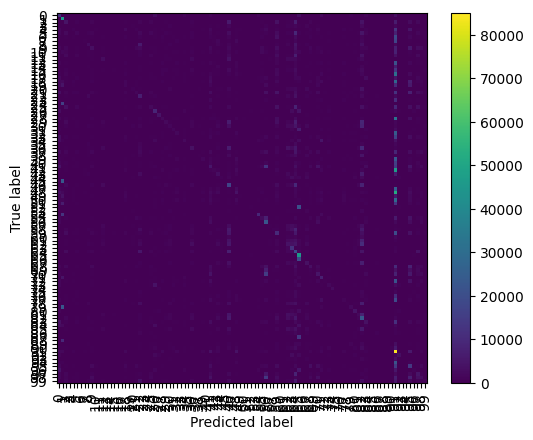

In [27]:
plot_confusion_matrix(model, x_train, y_train, include_values=False, xticks_rotation='vertical')
plt.show()

In [28]:
x_test

,site_name,user_location_country,user_location_region,user_location_city,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,is_booking,...,6,7,8,9,10,11,12,13,14,15
0,0.317676,0.302575,0.645854,0.413802,-0.497174,0.292735,1.138811,-0.439401,1.883760,1.0,...,-0.496219,-0.050654,-0.192579,-0.549451,0.274331,0.023771,0.198946,-0.062049,-0.208086,0.123279
1,-1.989083,-1.672814,1.418726,-0.679139,-0.497174,-0.557677,-1.042581,-0.439401,-0.257546,1.0,...,-0.408149,-0.604445,1.051436,-0.330756,0.775626,-0.758638,0.619963,-0.848316,-0.182229,-0.109004
2,0.317676,0.302575,0.660717,1.055044,2.011369,0.292735,-1.042581,-0.439401,-0.257546,1.0,...,-0.599064,0.261115,0.500078,-0.571276,-0.055772,0.116408,0.035461,-0.505666,-0.541628,0.082731
3,0.317676,0.302575,0.082949,0.013926,-0.497174,-1.762131,0.048115,-0.439401,-0.257546,1.0,...,-0.327941,-0.363837,1.076554,0.727485,0.351928,-0.664960,-0.022996,0.482492,-1.548487,-0.070707
4,0.317676,0.302575,-0.082655,-1.214412,-0.497174,0.292735,0.048115,-0.439401,-0.257546,1.0,...,0.707868,-1.320221,-0.519663,-0.523306,1.535987,-1.696778,-1.153276,-0.782239,-0.078219,-0.348557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597630,0.317676,0.302575,-1.155216,-0.247095,-0.497174,0.292735,-1.042581,0.991946,-0.257546,1.0,...,0.014679,-0.406158,0.300804,0.590209,1.444413,-0.952551,1.227582,-0.275525,-1.565700,-0.879907
597631,0.317676,0.302575,0.877702,0.600830,-0.497174,-0.876604,-1.042581,-0.439401,-0.257546,1.0,...,-0.032040,-0.070957,1.376767,0.500155,0.049052,-1.300181,0.246611,-0.193687,0.009912,0.057975
597632,-2.124488,-2.206090,-1.974187,-0.610687,2.011369,-0.876604,-1.042581,0.991946,-0.257546,1.0,...,-0.559773,0.541258,0.914044,-0.495068,0.360950,-0.073677,0.571784,-0.277445,-0.592638,-1.222122
597633,0.317676,0.302575,-0.277677,-0.193643,-0.497174,0.292735,2.229508,-0.439401,4.025067,1.0,...,-0.124745,1.329070,0.521845,-2.355366,0.135271,-1.231283,-0.501801,-0.229624,0.840470,2.100703


In [29]:
model.predict_proba(x_test)

array([[1.64846258e-04, 3.43090647e-05, 6.72915044e-03, ...,
        9.64971340e-04, 1.86177380e-03, 9.66426839e-03],
       [8.90776701e-05, 5.73658477e-07, 3.38142994e-03, ...,
        3.25146816e-03, 3.08821666e-04, 1.68350928e-02],
       [3.77922610e-07, 6.27120373e-06, 5.95047779e-03, ...,
        8.76221196e-05, 3.76025276e-05, 2.50401192e-03],
       ...,
       [3.40617309e-04, 1.30844368e-05, 3.29457585e-03, ...,
        8.01843408e-03, 9.68733227e-04, 8.26303557e-03],
       [1.06852582e-03, 6.07012835e-05, 1.90385178e-02, ...,
        1.34690557e-02, 2.50778554e-02, 6.01467611e-02],
       [2.82650100e-04, 5.66876713e-05, 2.14029915e-02, ...,
        2.12105908e-02, 9.85644999e-03, 4.71661692e-02]])

In [30]:
x_train

,site_name,user_location_country,user_location_region,user_location_city,is_package,channel,srch_adults_cnt,srch_children_cnt,srch_rm_cnt,is_booking,...,6,7,8,9,10,11,12,13,14,15
0,0.317676,0.302575,0.877702,0.163734,2.011369,0.292735,-1.042581,-0.439401,-0.257546,1.0,...,3.880107,1.166259,-0.551635,-0.366335,2.270325,-0.397585,-2.880989,0.703542,1.357947,-0.842985
1,0.317676,0.302575,1.418726,0.427955,2.011369,-0.557677,0.048115,-0.439401,-0.257546,-1.0,...,0.531296,-0.546425,-1.410273,-0.323264,-0.337281,1.177257,0.941866,-0.111843,-0.373480,0.037584
2,-2.124488,-2.291013,-2.510071,-1.042564,2.011369,0.292735,0.048115,-0.439401,-0.257546,1.0,...,-0.140580,0.009895,0.088969,-1.526010,-0.478655,-1.184208,0.430835,0.922576,1.351358,0.073718
3,1.588288,1.723476,1.557957,0.504597,2.011369,0.292735,0.048115,-0.439401,-0.257546,-1.0,...,-1.032235,0.191134,-1.151626,0.312742,0.607547,-2.020392,-0.808565,-0.137314,-0.138752,-0.128901
4,0.132685,0.333459,0.285187,-0.365167,-0.497174,0.969671,-1.042581,-0.439401,-0.257546,1.0,...,-0.480934,-0.360634,-0.384210,1.364789,-0.734222,-0.677575,-0.241784,1.276861,-1.018823,-1.969919
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3824862,0.317676,0.302575,0.183712,-0.161435,-0.497174,0.292735,-1.042581,-0.439401,-0.257546,-1.0,...,0.014732,-0.103308,0.773896,-1.199752,-0.457235,0.972831,-0.007668,0.612434,0.784004,-0.728165
3824863,0.317676,0.302575,1.796643,0.855440,-0.497174,0.292735,-1.042581,-0.439401,-0.257546,1.0,...,3.880107,1.166259,-0.551635,-0.366335,2.270325,-0.397585,-2.880989,0.703542,1.357947,-0.842985
3824864,-1.638386,0.279877,0.074631,-0.029223,-0.497174,0.292735,1.138811,-0.439401,-0.257546,-1.0,...,0.112574,1.003315,-1.279184,-0.757364,-0.431126,0.714172,0.817488,0.913947,-0.094780,0.210874
3824865,0.317676,0.302575,0.183712,0.037699,-0.497174,0.164190,0.048115,-0.439401,-0.257546,1.0,...,-0.558778,0.124679,0.939222,-0.528300,-0.128367,-0.558150,0.608802,-1.175832,-0.015633,-0.636385


In [31]:
# predict 5 hotel clusters 
def predict_test(model, x, y):
    book_prob = pd.DataFrame(model.predict_proba(x), index=x.index)
    display(book_prob)
    
    top_5 = book_prob.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=5)
    
    total_num = len(top_5)
    
    pred_true = pd.DataFrame(np.tile(y.to_numpy(), (5,1)).T, index=x.index) == top_5
    correct_num = pred_true.sum().sum()
    
    accuracy = correct_num/total_num
    print('accuracy in testing set: ', accuracy)
    display(top_5)
    
    map_5 = 0
    for i in range(5):
        map_5 += (pred_true.sum()/len(y))[i]*(1/(i+1))
    print('map@5: ', map_5)

In [32]:
predict_test(model, x_test, y_test)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.648463e-04,3.430906e-05,0.006729,0.002178,0.005893,0.011507,0.026292,0.024693,0.004679,0.005203,...,0.007309,0.125853,0.000653,0.002067,0.030359,0.008852,0.002695,0.000965,0.001862,0.009664
1,8.907767e-05,5.736585e-07,0.003381,0.007448,0.000899,0.019565,0.015660,0.010346,0.028738,0.001229,...,0.005045,0.000165,0.001124,0.003922,0.000025,0.000446,0.001367,0.003251,0.000309,0.016835
2,3.779226e-07,6.271204e-06,0.005950,0.002957,0.001130,0.006493,0.011665,0.054402,0.002046,0.002722,...,0.007299,0.115523,0.000014,0.004209,0.063303,0.000585,0.000455,0.000088,0.000038,0.002504
3,7.801194e-03,4.834227e-05,0.004909,0.001290,0.013770,0.011398,0.012686,0.001611,0.000411,0.016909,...,0.003685,0.043279,0.000858,0.001083,0.008875,0.034722,0.012715,0.012237,0.052115,0.008611
4,1.017108e-01,2.516383e-04,0.007493,0.004743,0.026299,0.035234,0.016460,0.002249,0.003652,0.012131,...,0.015101,0.000184,0.001359,0.004003,0.000016,0.007392,0.021758,0.010622,0.013153,0.034260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597630,2.687299e-05,2.509200e-05,0.011783,0.001013,0.016946,0.005880,0.023237,0.012995,0.000319,0.005336,...,0.003170,0.147572,0.000016,0.001095,0.032210,0.017456,0.000907,0.000998,0.001492,0.003556
597631,4.135957e-05,6.205408e-06,0.037159,0.012943,0.009513,0.040888,0.024397,0.006958,0.004233,0.016006,...,0.009714,0.003523,0.000085,0.005210,0.000062,0.006075,0.000796,0.008703,0.005062,0.017674
597632,3.406173e-04,1.308444e-05,0.003295,0.014527,0.000540,0.018690,0.006180,0.006644,0.025097,0.001841,...,0.010639,0.001042,0.011226,0.005010,0.000361,0.000689,0.005965,0.008018,0.000969,0.008263
597633,1.068526e-03,6.070128e-05,0.019039,0.001647,0.007026,0.021057,0.031768,0.004793,0.003894,0.028477,...,0.002064,0.002566,0.001072,0.000358,0.000338,0.030672,0.001960,0.013469,0.025078,0.060147


[[15 15 15 15 15]
 [67 67 67 67 67]
 [43 43 43 43 43]
 ...
 [ 5  5  5  5  5]
 [21 21 21 21 21]
 [ 9  9  9  9  9]]
accuracy in testing set:  0.3719644933780652


,0,1,2,3,4
0,91,48,42,16,50
1,61,62,81,82,30
2,48,91,42,94,47
3,49,18,98,21,41
4,0,17,21,10,37
...,...,...,...,...,...
597630,91,42,48,16,77
597631,25,5,2,59,28
597632,63,61,81,30,64
597633,59,99,46,64,21


In [ ]:
###################

In [41]:
book_prob = pd.DataFrame(model.predict_proba(x_test), index=x_test.index)
display(book_prob)

top_5 = book_prob.apply(lambda s, n: pd.Series(s.nlargest(n).index), axis=1, n=5)
display(top_5)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.648463e-04,3.430906e-05,0.006729,0.002178,0.005893,0.011507,0.026292,0.024693,0.004679,0.005203,...,0.007309,0.125853,0.000653,0.002067,0.030359,0.008852,0.002695,0.000965,0.001862,0.009664
1,8.907767e-05,5.736585e-07,0.003381,0.007448,0.000899,0.019565,0.015660,0.010346,0.028738,0.001229,...,0.005045,0.000165,0.001124,0.003922,0.000025,0.000446,0.001367,0.003251,0.000309,0.016835
2,3.779226e-07,6.271204e-06,0.005950,0.002957,0.001130,0.006493,0.011665,0.054402,0.002046,0.002722,...,0.007299,0.115523,0.000014,0.004209,0.063303,0.000585,0.000455,0.000088,0.000038,0.002504
3,7.801194e-03,4.834227e-05,0.004909,0.001290,0.013770,0.011398,0.012686,0.001611,0.000411,0.016909,...,0.003685,0.043279,0.000858,0.001083,0.008875,0.034722,0.012715,0.012237,0.052115,0.008611
4,1.017108e-01,2.516383e-04,0.007493,0.004743,0.026299,0.035234,0.016460,0.002249,0.003652,0.012131,...,0.015101,0.000184,0.001359,0.004003,0.000016,0.007392,0.021758,0.010622,0.013153,0.034260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
597630,2.687299e-05,2.509200e-05,0.011783,0.001013,0.016946,0.005880,0.023237,0.012995,0.000319,0.005336,...,0.003170,0.147572,0.000016,0.001095,0.032210,0.017456,0.000907,0.000998,0.001492,0.003556
597631,4.135957e-05,6.205408e-06,0.037159,0.012943,0.009513,0.040888,0.024397,0.006958,0.004233,0.016006,...,0.009714,0.003523,0.000085,0.005210,0.000062,0.006075,0.000796,0.008703,0.005062,0.017674
597632,3.406173e-04,1.308444e-05,0.003295,0.014527,0.000540,0.018690,0.006180,0.006644,0.025097,0.001841,...,0.010639,0.001042,0.011226,0.005010,0.000361,0.000689,0.005965,0.008018,0.000969,0.008263
597633,1.068526e-03,6.070128e-05,0.019039,0.001647,0.007026,0.021057,0.031768,0.004793,0.003894,0.028477,...,0.002064,0.002566,0.001072,0.000358,0.000338,0.030672,0.001960,0.013469,0.025078,0.060147


,0,1,2,3,4
0,91,48,42,16,50
1,61,62,81,82,30
2,48,91,42,94,47
3,49,18,98,21,41
4,0,17,21,10,37
...,...,...,...,...,...
597630,91,42,48,16,77
597631,25,5,2,59,28
597632,63,61,81,30,64
597633,59,99,46,64,21


In [43]:
pred_true = pd.DataFrame(np.tile(y_test.to_numpy(), (5,1)).T, index=x_test.index) == top_5
pred_true

,0,1,2,3,4
0,False,False,False,False,False
1,False,False,False,False,False
2,False,False,False,False,False
3,False,False,False,False,False
4,True,False,False,False,False
...,...,...,...,...,...
597630,False,False,True,False,False
597631,False,False,False,False,False
597632,False,False,False,False,False
597633,False,False,False,False,True


In [49]:
map_5 = 0
for i in range(5):
    map_5 += (pred_true.sum()/len(y_test))[i]*(1/(i+1))

In [50]:
map_5

0.2059808801916443

In [ ]:
##############################

In [92]:
x_train.columns

Index([                 'site_name',      'user_location_country',
             'user_location_region',         'user_location_city',
                       'is_package',                    'channel',
                  'srch_adults_cnt',          'srch_children_cnt',
                      'srch_rm_cnt',                 'is_booking',
                              'cnt',            'hotel_continent',
                    'hotel_country',               'hotel_market',
                   'srch_before_ci',         'srch_trip_duration',
         'encoded_day_of_year_srch', 'srch_destination_type_id_0',
       'srch_destination_type_id_1', 'srch_destination_type_id_2',
       'srch_destination_type_id_3', 'srch_destination_type_id_4',
       'srch_destination_type_id_5', 'srch_destination_type_id_6',
       'srch_destination_type_id_7', 'srch_destination_type_id_8',
       'srch_destination_type_id_9',                            0,
                                  1,                          

In [101]:
x_labels = x_train.columns[0:27].to_list()
for i in range(16):
    x_labels.extend(['srch_destination_PCA_'+str(i)])
x_labels

['site_name',
 'user_location_country',
 'user_location_region',
 'user_location_city',
 'is_package',
 'channel',
 'srch_adults_cnt',
 'srch_children_cnt',
 'srch_rm_cnt',
 'is_booking',
 'cnt',
 'hotel_continent',
 'hotel_country',
 'hotel_market',
 'srch_before_ci',
 'srch_trip_duration',
 'encoded_day_of_year_srch',
 'srch_destination_type_id_0',
 'srch_destination_type_id_1',
 'srch_destination_type_id_2',
 'srch_destination_type_id_3',
 'srch_destination_type_id_4',
 'srch_destination_type_id_5',
 'srch_destination_type_id_6',
 'srch_destination_type_id_7',
 'srch_destination_type_id_8',
 'srch_destination_type_id_9',
 'srch_destination_PCA_0',
 'srch_destination_PCA_1',
 'srch_destination_PCA_2',
 'srch_destination_PCA_3',
 'srch_destination_PCA_4',
 'srch_destination_PCA_5',
 'srch_destination_PCA_6',
 'srch_destination_PCA_7',
 'srch_destination_PCA_8',
 'srch_destination_PCA_9',
 'srch_destination_PCA_10',
 'srch_destination_PCA_11',
 'srch_destination_PCA_12',
 'srch_destina

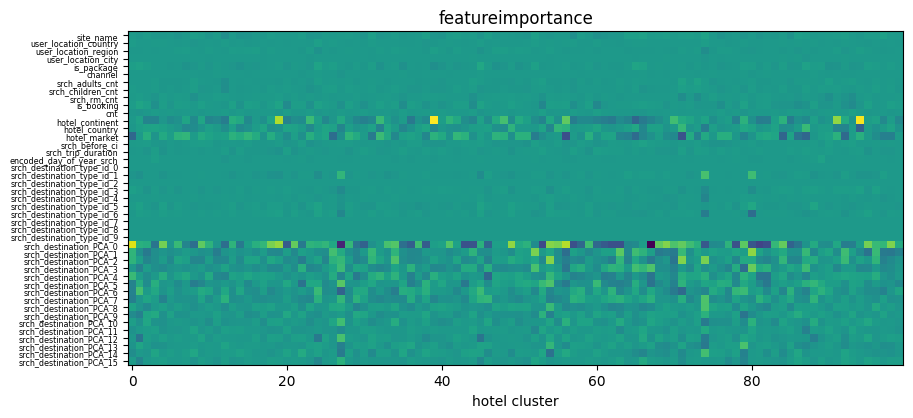

In [106]:
plt.subplots(figsize=(10,6))
plt.imshow(model.coef_.T)
#plt.xticks(x_train.columns)
plt.xlabel('hotel cluster')
plt.yticks(np.arange(0,len(x_train.columns)), x_labels, size='xx-small')
plt.title('featureimportance')
plt.show()

# SVC

In [52]:
svm_model = LinearSVC(dual=False, multi_class='ovr', tol=0.01).fit(x_train,y_train, callbacks=callback)

In [56]:
# train score
print('score on training set: ', svm_model.score(x_train,y_train))
#val score
print('score on validation set: ', svm_model.score(x_val,y_val))

score on training set:  0.11366120704327759
score on validation set:  0.1138099406306309


In [58]:
#test score
svm_model.score(x_test,y_test)

0.11374166506312382

In [62]:
# MAP@5 score equals accuracy score.. B.c. SVM doesn't predict probability, and can't predict multiple class

# Random forest

In [ ]:
rfc_model = RandomForestClassifier(n_estimators=20, max_depth = 50).fit(x_train,y_train, callbacks=callback)